# Прогнозирование цен на гостиничные номера в центре Чикаго

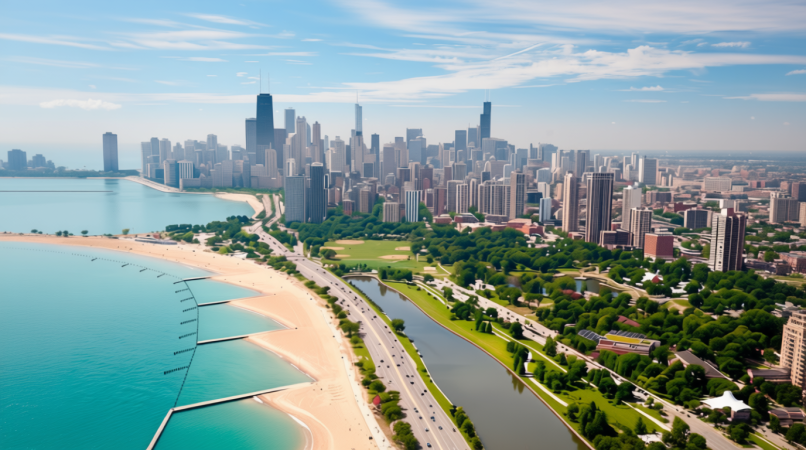

`Общее описание данных` ([источник](http://www.choosechicago.com/))

Данные представляют собой ежемесячную статистику по гостиницам в центральном деловом районе Чикаго (Chicago Central Business District Hotel Statistics) за период с 1994 по 2003 год.

Набор данных включает временные метки и ключевой показатель $-$ среднюю стоимость номера (Average Daily Rate, **ADR**) в долларах США, рассчитанную как среднее значение цены за номер в день по всем отелям и всем дням каждого месяца.
<br><br>
Последние **6 месяцев** будут выделены как **тестовая выборка** для прогноза ADR:

In [243]:
forecast_horizon = 6

# Импорт библиотек

In [244]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing

plt.style.use('ggplot')

# Загрузка данных

In [245]:
data = pd.read_csv('chicago_hotels.csv')

In [246]:
data.head()

,date1,date2,adr
0,January,1994,104.04
1,February,1994,102.74
2,March,1994,105.23
3,April,1994,113.63
4,May,1994,120.77


In [247]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date1   112 non-null    object 
 1   date2   112 non-null    int64  
 2   adr     112 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.8+ KB


Описательные статистики:

In [248]:
data.describe().round(2)

,date2,adr
count,112.00,112.00
mean,1998.18,143.84
std,2.71,22.48
min,1994.00,102.74
25%,1996.00,126.37
50%,1998.00,142.76
75%,2000.25,162.38
max,2003.00,190.71


Уникальные значения в столбце `date1`:

In [249]:
data.date1.unique()

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype=object)

Расчёт **среднего** значения **ADR** для каждого месяца:

In [250]:
data.groupby('date1')['adr'].mean()#.idxmin()

,adr
date1,
April,142.448000
August,145.182222
December,134.432222
February,125.594000
January,127.099000
July,136.101111
June,156.254444
March,133.362000
May,155.830000


Создадим единый столбец с датой, отсортируем данные по нему и удалим исходные столбцы с датами:

In [251]:
data['date'] = pd.to_datetime(
    data.date2.astype(str) + '-' + data.date1,
    format='%Y-%B'
).dt.to_period('M')

data = data.sort_values('date').reset_index(drop=True)
data = data.drop(columns=['date1', 'date2'])

In [252]:
data.tail()

,adr,date
107,148.95,2002-12
108,132.89,2003-01
109,127.44,2003-02
110,147.32,2003-03
111,150.72,2003-04


# Линейная регрессия

In [253]:
# Выборка для подгонки
X_train = data[:-forecast_horizon].drop(columns=['adr']).copy()
Y_train = data[:-forecast_horizon].adr.copy()

# Выборка для предсказания
X_test = data.drop(columns=['adr']).copy()
Y_test = data.adr.copy()

Визуализация распределения и динамики `ADR`:

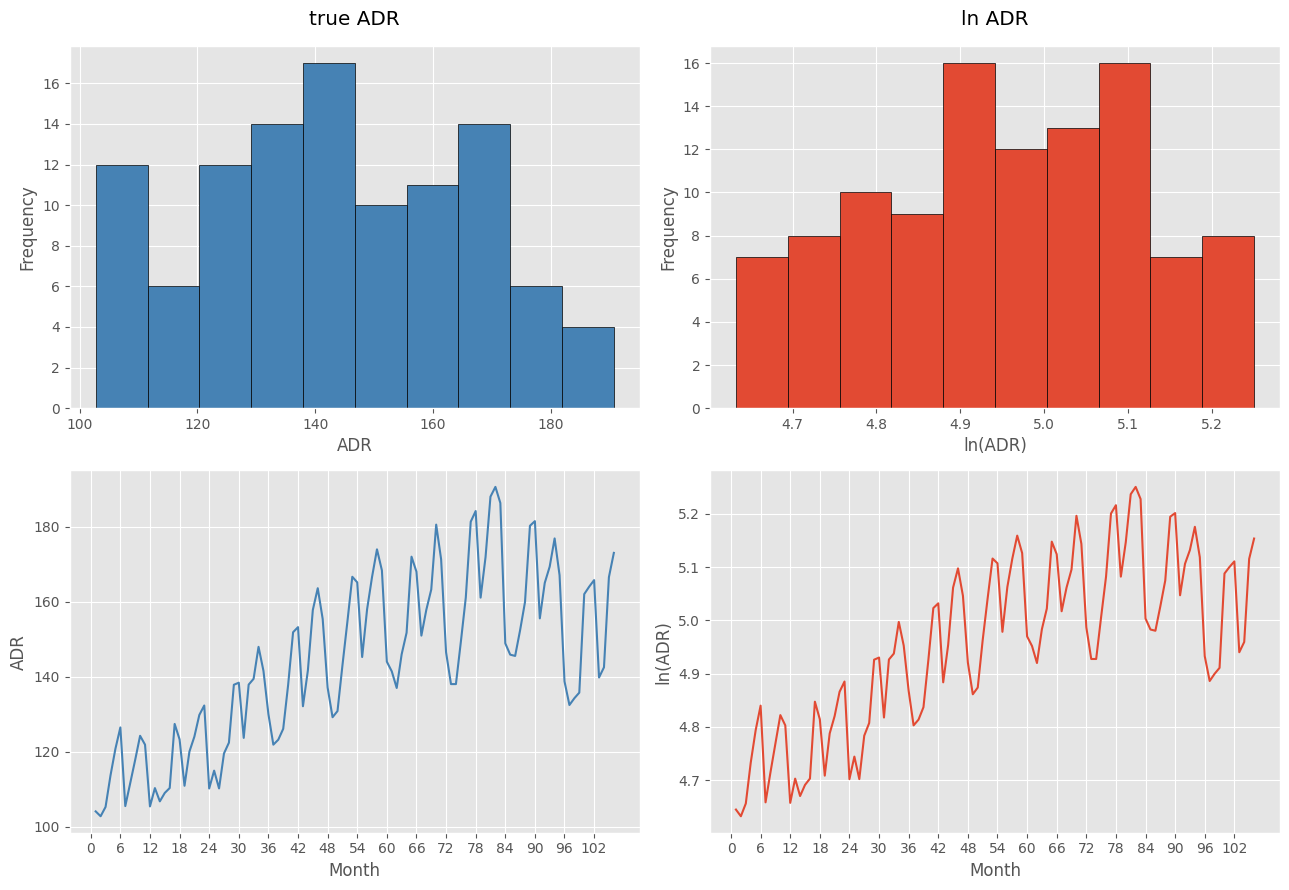

In [254]:
# Подготовка данных
log_Y_train = np.log(Y_train)
tick_positions = np.arange(0, len(Y_train) + 1, 6)

# Создание фигуры 2х2
fig, axes = plt.subplots(2, 2, figsize=(13, 9))

# Верхний левый: гистограмма ADR
axes[0, 0].hist(Y_train, bins=10, edgecolor='black', color='steelblue')
axes[0, 0].set_xlabel('ADR')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('true ADR', pad=15)

# Верхний правый: гистограмма ln(ADR)
axes[0, 1].hist(log_Y_train, bins=10, edgecolor='black')
axes[0, 1].set_xlabel('ln(ADR)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('ln ADR', pad=15)

# Нижний левый: временной ряд ADR
axes[1, 0].plot(range(1, len(Y_train) + 1), Y_train.values, color='steelblue')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('ADR')
axes[1, 0].set_xticks(tick_positions)

# Нижний правый: временной ряд ln(ADR)
axes[1, 1].plot(range(1, len(Y_train) + 1), log_Y_train.values)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('ln(ADR)')
axes[1, 1].set_xticks(tick_positions)

plt.tight_layout()
plt.show()

> Временной ряд ADR:
> * Устойчивый рост $-$ от 100 на старте до пика 190 долларов США к месяцу 84.
> * Ярко выраженная годовая сезонность $-$ пики повторяются каждые 12 месяцев.
> * После месяца 84 наблюдается снижение уровня ADR.

Следует учитывать наличие **разгонного периода** в начале временного ряда: первые N месяцев могут характеризоваться нестабильной динамикой, вызванной, например, запуском отеля, формированием клиентской базы или иными стартовыми факторами. Такие наблюдения хуже отражают устойчивые долгосрочные паттерны и могут вносить смещение в модель. В таких случаях целесообразно исключить начальные точки из обучающей выборки.

После применения **логарифмического преобразования** временной ряд становится ближе к **аддитивной модели**.

Далее будем использовать модель вида:

$$
\ln(\text{ADR}) = \beta_0 + \beta_1 t + \beta_2 t^2 + \sum_{m=1}^{12} \gamma_m \cdot \mathbb{I}(\text{month} = m) + \varepsilon
$$

где

* $t$ $-$ номер месяца от начала наблюдений (линейный тренд),  
* $t^{2}$ $-$ квадрат этого номера (нелинейная компонента тренда),  
* $\mathbb{I}(\text{month} = m)$ $-$ бинарные индикаторы календарных месяцев (сезонность),  
* $\beta_0, \beta_1, \beta_2, \gamma_m$ $-$ оцениваемые коэффициенты,  
* $\varepsilon$ $-$ случайная ошибка.  

Один из месяцев (**базовый**) исключается из модели во избежание **мультиколлинеарности**. В результате коэффициенты при остальных месяцах интерпретируются не как абсолютные сезонные поправки, а как относительные отклонения от базового месяца.

Для оценки качества модели линейной регрессии будем использовать метрику `MAPE` (Mean Absolute Percentage Error).
<br><br>
Подготовим данные:

In [255]:
# Бинарные индикаторы календарных месяцев
def add_month_dummies(df, date_col='date', drop_month=None):
    df = df.copy()
    if drop_month is not None:
        if not (1 <= drop_month <= 12):
            raise ValueError('drop_month должен быть целым числом от 1 до 12 или None.')

    for month in range(1, 13):
        if drop_month is None or month != drop_month:
            df[f'month_{month}'] = (df[date_col].dt.month == month).astype(int)

    return df

drop_month = 2  # базовый месяц (февраль)
X_train = add_month_dummies(df=X_train, drop_month=drop_month)
X_test = add_month_dummies(df=X_test, drop_month=drop_month)


# Остальные преобразования
X_train['month_num'] = range(1, len(X_train) + 1)
X_train['month_num_square'] = X_train.month_num ** 2
X_train = X_train.drop(columns=['date'])
Y_train = np.log(Y_train)

X_test['month_num'] = range(1, len(X_test) + 1)
X_test['month_num_square'] = X_test.month_num ** 2
X_test = X_test.drop(columns=['date'])
Y_test = np.log(Y_test)

Когда мы моделируем **логарифм целевой переменной**

$$
z = \ln y
$$

и обучаем модель линейной регрессии (минимизирующую **MSE**), мы фактически предсказываем **среднее значение логарифма**

$$
\hat{z} = \mathbb{E}[\ln y \mid x].
$$

Но нам нужно предсказать саму переменную $y$ (ADR в долларах США).

---

Следствие **неравенства Йенсена**: для выпуклой функции $\phi$ ($e^x$ $-$ выпуклая) выполняется

$$
\mathbb{E}[\phi(X)] \ge \phi(\mathbb{E}[X])
$$

или

$$
\mathbb{E}[y \mid x] = \mathbb{E}[e^{\ln y} \mid x] \ge e^{\mathbb{E}[\ln y \mid x]} = e^{\hat{z}},
$$

то есть **$e^{\hat{z}}$ систематически занижает среднее значение $y$**.

---

Ошибки в лог-масштабе почти нормальны, то есть

$$
\varepsilon \sim \mathcal{N}(0, \sigma^2),
$$

тогда при фиксированном $x$

$$
\ln y \mid x \sim \mathcal{N}(\mu, \sigma^2).
$$

Следовательно, $y \mid x$ имеет **логнормальное распределение**. Теперь посчитаем его математическое ожидание:

$$
\mathbb{E}[y \mid x] = \mathbb{E}[e^{\ln y} \mid x] = \mathbb{E}[e^{X}].
$$

А математическое ожидание $\mathbb{E}[e^{tX}]$ для нормальной случайной величины $-$ это **момент-производящая функция**:

$$
\mathbb{E}[e^{tX}] = e^{(\mu t + \frac{1}{2} \sigma^2 t^2)}.
$$

Подставляем $t=1$:

$$
\mathbb{E}[e^{X}] = e^{(\mu + \frac{1}{2} \sigma^2)}.
$$

---

Окончательно (практические формулы):

$$
\hat{\sigma}^2 = \frac{1}{n - p} \sum_{i=1}^n (z_i - \hat{z}_i)^2, \quad \hat{y} = e^{(\hat{z} + \frac{1}{2} \hat{\sigma}^2)},
$$

где $p$ $-$ число параметров модели.

---
<br><br>
Выполним `подгонку` модели:

Поправка на несмещённость: 0.0004758265853473214



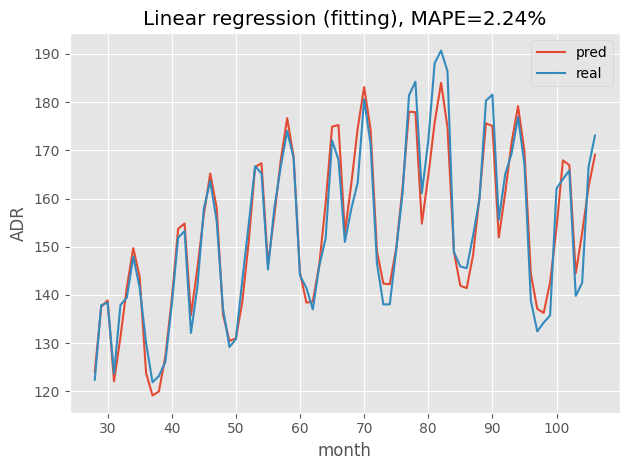

In [256]:
# Подготовка данных
start_months = 28  # месяц, с которого начинаем учиться
mask = (X_train.month_num >= start_months)
X_subset = X_train[mask].copy()
y_log_true = Y_train[mask].values.copy()
y_true = np.exp(y_log_true)

# Сохраняем оригинальные "month_num" для графика
X_month_nums = X_subset.month_num.values

# Стандартизация числовых признаков
scaler = StandardScaler()
X_subset[['month_num', 'month_num_square']] = scaler.fit_transform(X_subset[['month_num', 'month_num_square']])

# Обучение и предсказания
model = LinearRegression()
model.fit(X_subset, y_log_true)
y_log_pred = model.predict(X_subset)

# Остатки и дисперсия
residuals = y_log_true - y_log_pred
n = X_subset.shape[0]
p = X_subset.shape[1] + 1
sigma2 = np.sum(residuals**2) / (n - p)
y_pred = np.exp(y_log_pred + 0.5*sigma2)  # предсказания с поправкой
print(f'Поправка на несмещённость: {0.5*sigma2}', end=2*'\n')

# Метрика
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Визуализация
pd.DataFrame({
    'pred': y_pred,
    'real': y_true
}, index=X_month_nums).plot()
plt.xlabel('month')
plt.ylabel('ADR')
plt.title(f'Linear regression (fitting), MAPE={mape:.2f}%')
plt.tight_layout()
plt.show()


Выполним `предсказание`:

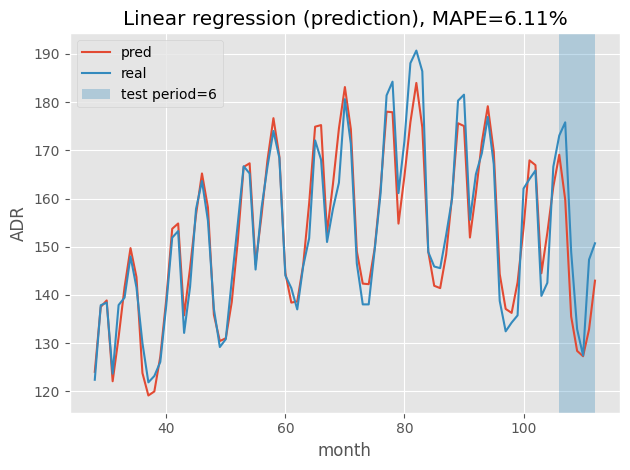

In [257]:
# Подготовка данных
start_months = 28  # месяц, с которого начинаем учиться
mask_train = (X_train.month_num >= start_months)
mask_test = (X_test.month_num >= start_months)

train_subset = X_train[mask_train].copy()
test_subset = X_test[mask_test].copy()
y_train = Y_train[mask_train].values.copy()
y_true = np.exp(Y_test[mask_test].values)

# Сохраняем оригинальные "month_num" для графика
train_month_nums = train_subset.month_num.values
test_month_nums = test_subset.month_num.values

# Стандартизация числовых признаков
scaler = StandardScaler()
numeric_features = ['month_num', 'month_num_square']
train_subset[numeric_features] = scaler.fit_transform(train_subset[numeric_features])
test_subset[numeric_features] = scaler.transform(test_subset[numeric_features])

# Обучение
model = LinearRegression()
model.fit(train_subset, y_train)

# Остатки и дисперсия
residuals_train = y_train - model.predict(train_subset)
n = train_subset.shape[0]
p = train_subset.shape[1] + 1
sigma2 = np.sum(residuals_train**2) / (n - p)

# Предсказание на тесте с поправкой
y_pred = np.exp(model.predict(test_subset) + 0.5*sigma2)

# Метрика на тесте
mape = np.mean(np.abs((y_true[-forecast_horizon:] - y_pred[-forecast_horizon:]) / y_true[-forecast_horizon:])) * 100

# Визуализация
pd.DataFrame({
    'pred': y_pred,
    'real': y_true
}, index=test_month_nums).plot()
plt.xlabel('month')
plt.ylabel('ADR')
plt.title(f'Linear regression (prediction), MAPE={mape:.2f}%')

train_end = train_month_nums.max()
test_end = test_month_nums.max()
plt.axvspan(train_end, test_end, alpha=0.3, label=f'test period={forecast_horizon}')
plt.legend()
plt.tight_layout()
plt.show()

Коэффициенты + p-value:
> *Проверяем гипотезу о том, что коэффициент при предикторе равен нулю.
Если p-value < 0.05, мы заключаем, что предиктор значимо влияет.*

In [258]:
X = train_subset
y = y_train
n, k = X.shape
df = n - k - 1

resid = y - model.predict(X)
mse = np.sum(resid ** 2) / df
X1 = np.column_stack([np.ones(n), X.values])

try:
    se = np.sqrt(np.diag(mse * np.linalg.inv(X1.T @ X1)))
except np.linalg.LinAlgError:
    se = np.full(k + 1, np.nan)

coefs = np.concatenate([[model.intercept_], model.coef_])
t_vals = coefs / se
# Вычисление p-значений двустороннего t-критерия
pvals = [2 * (1 - stats.t.cdf(abs(t), df)) if not np.isnan(t) else np.nan for t in t_vals]

pd.DataFrame({
    'predictor': ['intercept'] + list(X.columns),
    'coef': coefs,
    'p-val': pvals
}).round(4)

,predictor,coef,p-val
0,intercept,4.8895,0.0000
1,month_1,0.0018,0.9209
2,month_3,0.0499,0.0067
3,month_4,0.1306,0.0000
4,month_5,0.2230,0.0000
5,month_6,0.2223,0.0000
6,month_7,0.0833,0.0000
7,month_8,0.1455,0.0000
8,month_9,0.2117,0.0000
9,month_10,0.2578,0.0000


> Базовым месяцем был выбран февраль $-$ он имеет наименьший средний ADR среди всех месяцев. В результате сезонные поправки для остальных месяцев оказались неотрицательными.
>
> В частности, сезонная поправка для января статистически не отличается от нуля (p-value = 0.92), что свидетельствует об отсутствии значимого различия в ADR между январём и февралём.

*Преимущества модели:*
- Хорошо справляется с короткими временными рядами.
- Способна моделировать как одну, так и несколько одновременных сезонностей.

*Недостатки модели:*
- Тренд задаётся фиксированным многочленом, что ограничивает гибкость при сложной динамике.
- Сезонность предполагается постоянной во времени, что может не соответствовать реальности при изменении поведения спроса.

# Экспоненциальное сглаживание

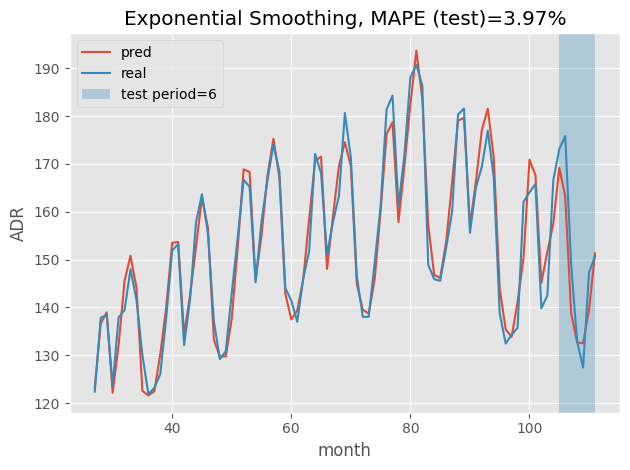

In [259]:
# Подготовка данных
start_months_idx = 27  # индекс месяца, с которого начинаем учиться
y_train = data.adr[start_months_idx:-forecast_horizon].copy()
y_test = data.adr[start_months_idx:].copy()

# Модель
model = ExponentialSmoothing(y_train, trend='add', seasonal='mul', seasonal_periods=12, damped_trend=True)
fit = model.fit()
fitvals = fit.fittedvalues
forecast = fit.forecast(steps=forecast_horizon)

# Метрика на тесте
mape = np.mean(np.abs((y_test[-forecast_horizon:] - forecast) / y_test[-forecast_horizon:])) * 100

# Визуализация
plt.plot(y_test.index, np.concatenate([fitvals, forecast]), label='pred')
plt.plot(y_test.index, y_test.values, label='real')

train_end = y_train.index.max()
test_end = y_test.index.max()
plt.axvspan(train_end, test_end, alpha=0.3, label=f'test period={forecast_horizon}')
plt.title(f'Exponential Smoothing, MAPE (test)={mape:.2f}%')
plt.xlabel('month')
plt.ylabel('ADR')

plt.tight_layout()
plt.legend()
plt.show()

> *Преимущества модели:*
> - Быстрая и простая реализация прогноза.
> - Тренд и сезонность динамически обновляются на каждом шаге, что позволяет модели адаптироваться к изменениям в данных.
>
> *Недостатки модели:*
> - Менее надёжна на коротких временных рядах.
> - Не поддерживает несколько сезонностей одновременно.

<br>

Анализ внутренней структуры модели:

In [260]:
# Параметры модели
fit.params

{'smoothing_level': np.float64(0.46633208044239005),
 'smoothing_trend': np.float64(0.0),
 'smoothing_seasonal': np.float64(0.0),
 'damping_trend': np.float64(0.950939841925086),
 'initial_level': np.float64(132.341151985099),
 'initial_trend': np.float64(2.12339416399515),
 'initial_seasons': array([0.91757849, 1.00584063, 1.00533993, 0.87453459, 0.92948752,
        0.99287058, 1.03833337, 0.99100496, 0.84202781, 0.80540793,
        0.8038432 , 0.84619484]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

> * `smoothing_level = 0.47` $-$ баланс между адаптацией к новым данным и подавлением шума.
>
> * `smoothing_trend = 0` и `smoothing_seasonal = 0` $-$ модель определила, что тренд и сезонность стабильны во времени, и выбрала их детерминированное (неадаптивное) представление.
>
> * `damping_trend = 0.95` $-$ тренд постепенно затухает.

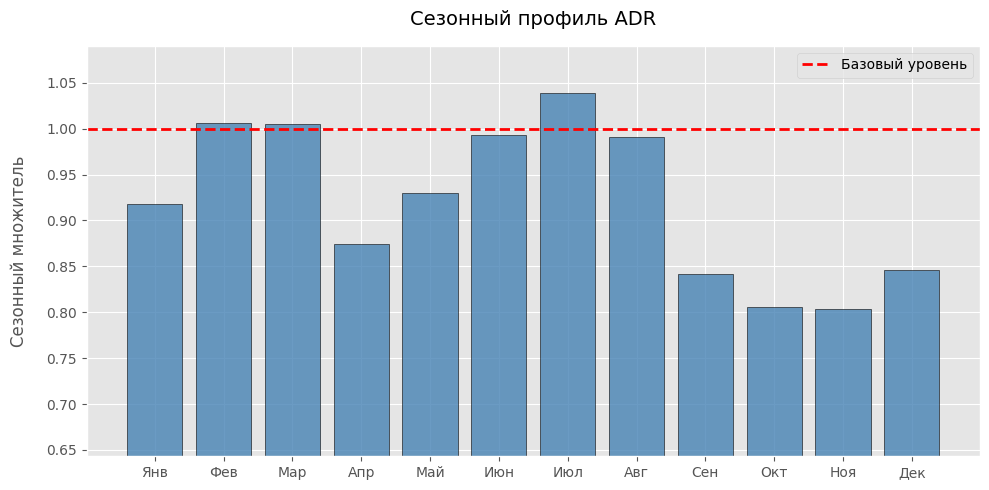

In [261]:
# Интерпретация сезонных коэффициентов
plt.figure(figsize=(10, 5))

seasonal_values = fit.params['initial_seasons']
months = ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн',
          'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек']

bars = plt.bar(months, seasonal_values, color='steelblue', edgecolor='black', alpha=0.8)
plt.axhline(1.0, color='red', linestyle='--', linewidth=2, label='Базовый уровень')  # линия базового уровня

plt.title('Сезонный профиль ADR', fontsize=14, pad=15)
plt.ylabel('Сезонный множитель', labelpad=13)
plt.ylim(seasonal_values.min()*0.8, seasonal_values.max()*1.05)
plt.legend()
plt.tight_layout()
plt.show()

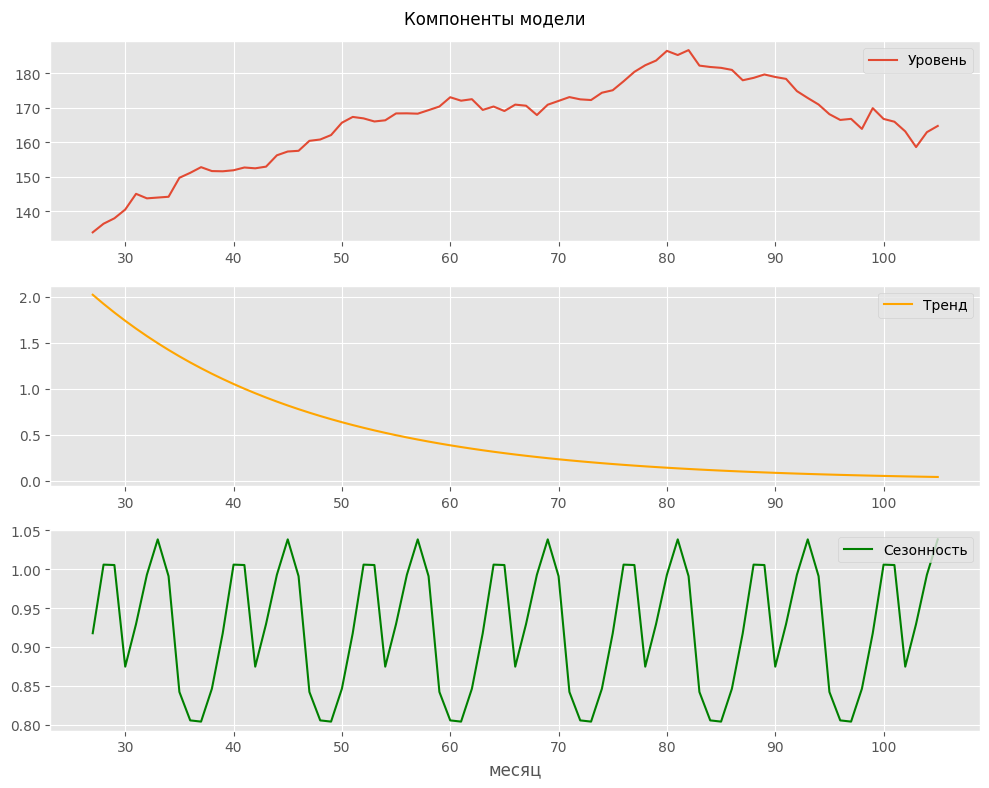

In [262]:
# Динамика компонентов модели во времени
plt.figure(figsize=(10, 8))
plt.suptitle('Компоненты модели')

plt.subplot(311)
plt.plot(fit.level, label='Уровень')
plt.legend()

plt.subplot(312)
plt.plot(fit.trend, label='Тренд', color='orange')
plt.legend()

plt.subplot(313)
plt.plot(fit.season, label='Сезонность', color='green')
plt.xlabel('месяц')
plt.legend()

plt.tight_layout()
plt.show()